In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier




In [2]:
reviews = pd.read_csv('reviews_cleaned.csv', delimiter=";")
reviews.head()

,Unnamed: 0,game_name,review_text,hours_played,rating,found_helpful,product_count,review_date,review_length
0,2,For The Warp,l 2020 EARLY ACCESS REVIEW It has the feel of ...,0.5,0.0,78.0,1004.0,"08 April, 2020",973
1,3,For The Warp,uary 2021 EARLY ACCESS REVIEW This is a tentat...,36.3,1.0,15.0,693.0,"10 January, 2021",853
2,4,For The Warp,uary EARLY ACCESS REVIEW Ultimately disappoint...,26.4,0.0,18.0,937.0,"18 January, 2022",724
3,7,For The Warp,st 2020 EARLY ACCESS REVIEW Like other reviews...,1.7,0.0,30.0,489.0,"05 August, 2020",527
4,9,For The Warp,l FTW doesnt have much of a story If any story...,18.6,0.0,12.0,462.0,"06 April, 2022",428


In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1785 non-null   int64  
 1   game_name      1785 non-null   object 
 2   review_text    1785 non-null   object 
 3   hours_played   1785 non-null   float64
 4   rating         1785 non-null   float64
 5   found_helpful  1785 non-null   float64
 6   product_count  1785 non-null   float64
 7   review_date    1785 non-null   object 
 8   review_length  1785 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 125.6+ KB


In [4]:
sorted_by_review_length = reviews.sort_values('review_length', axis=0)
sorted_by_review_length.head()
#I would still keep short reviews because "good" indicates positive sentiment already


,Unnamed: 0,game_name,review_text,hours_played,rating,found_helpful,product_count,review_date,review_length
661,762,Red Dead Redemption 2,good,9.2,1.0,0.0,28.0,"13 May, 2022",5
673,775,Red Dead Redemption 2,do it,7.1,1.0,0.0,151.0,"08 May, 2022",5
1476,1703,Rust,Good,174.5,1.0,1.0,2.0,"10 May, 2022",5
804,927,Subnautica: Below Zero,AL-AN,22.1,1.0,0.0,33.0,"09 May, 2022",5
1754,2024,Counter-Strike: Global Offensive,633,489.0,1.0,1.0,3.0,"10 May, 2022",5


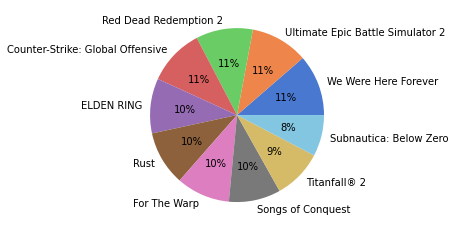

In [5]:
unique_games = reviews.game_name.unique()
colors = sns.color_palette('muted', n_colors=10, as_cmap=True)
game_dist = reviews.game_name.value_counts()
labels = game_dist.index.tolist()
plt.pie(game_dist, labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()


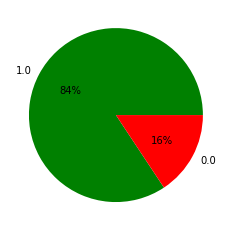

In [6]:
ratings_dist = reviews.rating.value_counts()
labels = ratings_dist.index.tolist()
plt.pie(ratings_dist, labels=labels, colors = ["green", "red"], autopct = '%0.0f%%')
plt.show()

<AxesSubplot:xlabel='game_name'>

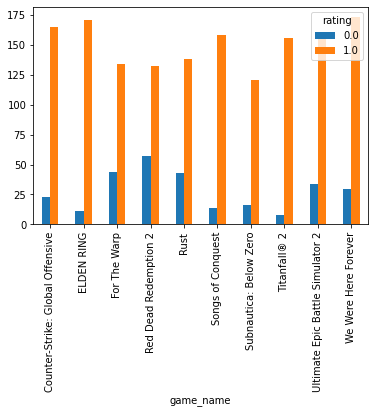

In [7]:
ratings = reviews.groupby(['game_name', 'rating']).rating.count().unstack()
ratings.plot(kind='bar')

In [8]:
X = reviews.drop('rating', axis=1)
y = reviews.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1195, 8), (1195,), (590, 8), (590,))

In [9]:
# Unigram Counts

X_train_texts = X_train.review_text

unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(X_train_texts)
X_train_unigram = unigram_vectorizer.transform(X_train_texts)


# Unigram Tf-Idf

unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)

X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)


# Bigram Counts

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(X_train_texts)
X_train_bigram = bigram_vectorizer.transform(X_train_texts)


# Bigram Tf-Idf

bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)


In [10]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.8, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nSGDClassifier: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')

    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'XGBoostClassifier: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

Unigram Counts
SGDClassifier: Train score: 1.0 ; Validation score: 0.84
XGBoostClassifier: Train score: 0.97 ; Validation score: 0.85

Unigram Tf-Idf
SGDClassifier: Train score: 1.0 ; Validation score: 0.86
XGBoostClassifier: Train score: 0.99 ; Validation score: 0.84

Bigram Counts
SGDClassifier: Train score: 1.0 ; Validation score: 0.87
XGBoostClassifier: Train score: 0.98 ; Validation score: 0.86

Bigram Tf-Idf
SGDClassifier: Train score: 1.0 ; Validation score: 0.88
XGBoostClassifier: Train score: 0.99 ; Validation score: 0.9



In [11]:
x_train_transformed = X_train_bigram_tf_idf #this had the best validation score (88%)
clf = SGDClassifier()

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4),
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50,
    n_jobs = -1,
)
random_search_cv.fit(x_train_transformed, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'alpha': 2.1896911773434634e-05, 'eta0': 0.006022058796328925, 'learning_rate': 'optimal', 'loss': 'log', 'penalty': 'l1'}
Best score: 0.8761506276150628


C:\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [12]:
sgd_classifier = random_search_cv.best_estimator_

#transform test data
x_test_transformed = bigram_vectorizer.transform(X_test.review_text)
x_test_transformed = bigram_tf_idf_transformer.transform(x_test_transformed)

#test score
score = sgd_classifier.score(x_test_transformed, y_test)
print("Test score SGD: ", score)


Test score SGD:  0.8525423728813559


In [13]:

clf = XGBClassifier()
clf.fit(x_train_transformed, y_train)
score = clf.score(x_test_transformed, y_test)
print("Test score XGB: ", score)


Test score XGB:  0.8152542372881356


In [14]:
'''
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    cv=5,
    n_iter=5
)
random_search_cv.fit(x_train_transformed, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

xgb_classifier = random_search_cv.best_estimator_

#test score
score = xgb_classifier.score(x_test_transformed, y_test)
print(score)
'''

"\nparams = {\n 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],\n 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],\n 'min_child_weight' : [ 1, 3, 5, 7 ],\n 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],\n 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]\n}\n\nrandom_search_cv = RandomizedSearchCV(\n    estimator=clf,\n    param_distributions=params,\n    cv=5,\n    n_iter=5\n)\nrandom_search_cv.fit(x_train_transformed, y_train)\nprint(f'Best params: {random_search_cv.best_params_}')\nprint(f'Best score: {random_search_cv.best_score_}')\n\nxgb_classifier = random_search_cv.best_estimator_\n\n#test score\nscore = xgb_classifier.score(x_test_transformed, y_test)\nprint(score)\n"

Confusion Matrix
[[ 41  72]
 [ 15 462]]


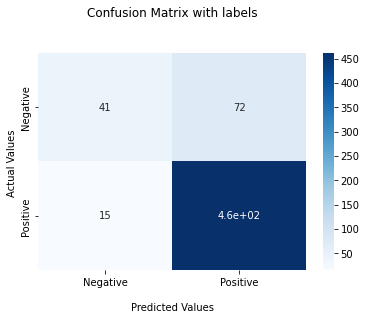


Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.36      0.49       113
         1.0       0.87      0.97      0.91       477

    accuracy                           0.85       590
   macro avg       0.80      0.67      0.70       590
weighted avg       0.84      0.85      0.83       590



In [15]:
y_pred = sgd_classifier.predict(x_test_transformed)

print("Confusion Matrix")
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Classification Report
print("\nClassification Report")
report = classification_report(y_test, y_pred)
print(report)


In [16]:
#let's see if there's games that get mispredicted more or less often
games = reviews.game_name
X_test.shape, y_pred.shape, y_test.shape

game_names = []
y_pred_list = []
y_true_list = []

for x, y_predictions, y_true in zip(X_test.game_name, y_pred, y_test):
    if(y_predictions != y_true):
        game_names.append(x)
        y_pred_list.append(y_predictions)
        y_true_list.append(y_true)

d = {'game_name': game_names, 'prediction': y_pred_list, 'true': y_true_list}
false_preds = pd.DataFrame(data=d)

false_preds.head()


,game_name,prediction,true
0,We Were Here Forever,0.0,1.0
1,We Were Here Forever,0.0,1.0
2,Red Dead Redemption 2,1.0,0.0
3,For The Warp,1.0,0.0
4,Rust,1.0,0.0


For The Warp                        18
Rust                                15
Red Dead Redemption 2               13
Counter-Strike: Global Offensive     9
Ultimate Epic Battle Simulator 2     8
We Were Here Forever                 7
ELDEN RING                           5
Songs of Conquest                    4
Subnautica: Below Zero               4
Titanfall® 2                         4
Name: game_name, dtype: int64


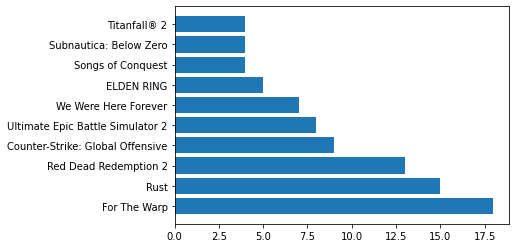

In [17]:
unique_games = false_preds.game_name.unique()
game_dist = false_preds.game_name.value_counts()
labels = game_dist.index.tolist()

print(game_dist)

plt.barh(range(0, len(unique_games)), width=game_dist.values, tick_label=labels)
plt.show()



In [18]:
from datetime import datetime

def get_date_object (date_string):
    date_time_obj = datetime.strptime(date_string, '%d %B, %Y')
    return date_time_obj

def get_year (date_object):
    return date_object.year

reviews['review_date_object'] = reviews.review_date.apply(get_date_object)
reviews['review_year'] = reviews.review_date_object.apply(get_year)

reviews

,Unnamed: 0,game_name,review_text,hours_played,rating,found_helpful,product_count,review_date,review_length,review_date_object,review_year
0,2,For The Warp,l 2020 EARLY ACCESS REVIEW It has the feel of ...,0.5,0.0,78.0,1004.0,"08 April, 2020",973,2020-04-08,2020
1,3,For The Warp,uary 2021 EARLY ACCESS REVIEW This is a tentat...,36.3,1.0,15.0,693.0,"10 January, 2021",853,2021-01-10,2021
2,4,For The Warp,uary EARLY ACCESS REVIEW Ultimately disappoint...,26.4,0.0,18.0,937.0,"18 January, 2022",724,2022-01-18,2022
3,7,For The Warp,st 2020 EARLY ACCESS REVIEW Like other reviews...,1.7,0.0,30.0,489.0,"05 August, 2020",527,2020-08-05,2020
4,9,For The Warp,l FTW doesnt have much of a story If any story...,18.6,0.0,12.0,462.0,"06 April, 2022",428,2022-04-06,2022
...,...,...,...,...,...,...,...,...,...,...,...
1780,2059,Counter-Strike: Global Offensive,Fun To play with friends,798.6,1.0,1.0,9.0,"09 May, 2022",24,2022-05-09,2022
1781,2060,Counter-Strike: Global Offensive,very addictive,105.3,1.0,1.0,2.0,"09 May, 2022",14,2022-05-09,2022
1782,2063,Counter-Strike: Global Offensive,I learned a lot of racial slurs and got a 30-d...,428.0,1.0,1.0,3.0,"09 May, 2022",77,2022-05-09,2022
1783,2064,Counter-Strike: Global Offensive,1/10 cant alt+f4,78.4,0.0,1.0,126.0,"09 May, 2022",17,2022-05-09,2022


In [23]:
'''
ratings = reviews.groupby(['game_name', 'review_year']).rating.mean().unstack
ratings

reviews.groupby(by=[reviews.review_date_object.dt.year, reviews.review_date_object.dt.month, reviews.game_name]).mean()
'''

"\nratings = reviews.groupby(['game_name', 'review_year']).rating.mean().unstack\nratings\n\nreviews.groupby(by=[reviews.review_date_object.dt.year, reviews.review_date_object.dt.month, reviews.game_name]).mean()\n"

<AxesSubplot:xlabel='Average review length per game', ylabel='review lenght'>

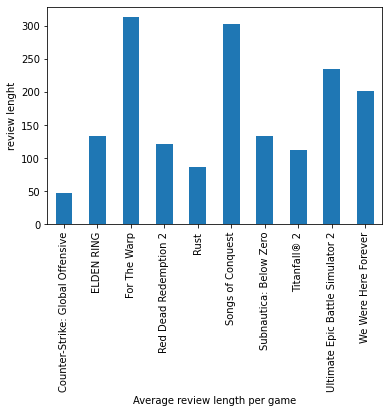

In [24]:
review_len = reviews.groupby(['game_name']).review_length.mean()
review_len.plot(kind='bar',  xlabel = 'Average review length per game', ylabel = 'review lenght')

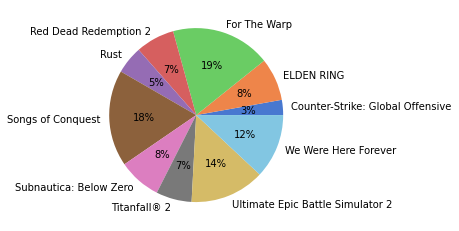

In [25]:
unique_games = reviews.game_name.unique()
colors = sns.color_palette('muted', n_colors=10, as_cmap=True)
labels = review_len.index.tolist()
plt.pie(review_len, labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()

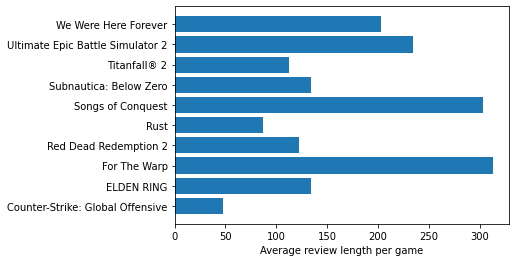

In [26]:
labels = review_len.index.tolist()
unique_games = reviews.game_name.unique()
plt.xlabel('Average review length per game')
plt.barh(range(0, len(unique_games)), width=review_len.values, tick_label=labels)
plt.show()

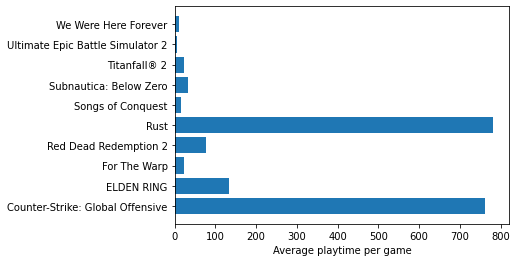

In [27]:
playtime = reviews.groupby(['game_name']).hours_played.mean()
unique_games = reviews.game_name.unique()
labels = playtime.index.tolist()
plt.xlabel('Average playtime per game')
plt.barh(range(0, len(unique_games)), width=playtime.values, tick_label=labels)
plt.show()

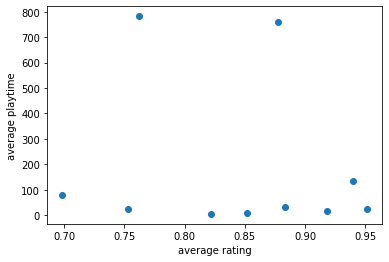

In [28]:
avg_rating = reviews.groupby(['game_name']).rating.mean()
plt.scatter(avg_rating, playtime)
plt.ylabel("average playtime")
plt.xlabel("average rating");

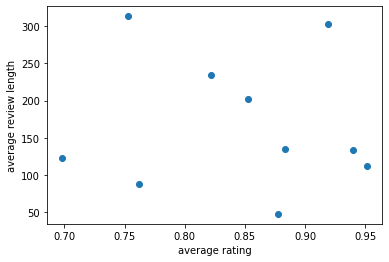

In [29]:
plt.scatter(avg_rating, review_len)
plt.ylabel("average review length")
plt.xlabel("average rating");

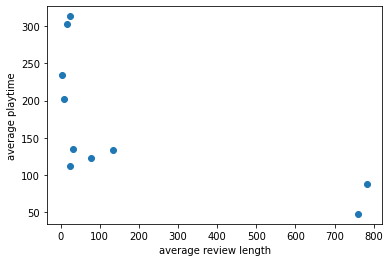

In [30]:
plt.scatter(playtime, review_len)
plt.ylabel("average playtime")
plt.xlabel("average review length");

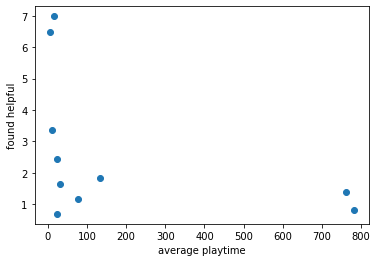

In [31]:
avg_helpfulness = reviews.groupby(['game_name']).found_helpful.mean()
plt.scatter(playtime, avg_helpfulness)
plt.xlabel("average playtime")
plt.ylabel("found helpful");

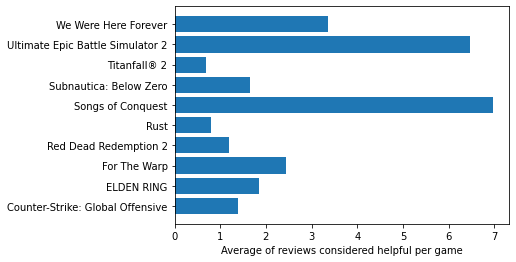

In [32]:
labels = avg_helpfulness.index.tolist()
unique_games = reviews.game_name.unique()
plt.xlabel('Average of reviews considered helpful per game')
plt.barh(range(0, len(unique_games)), width=avg_helpfulness.values, tick_label=labels)
plt.show()

<AxesSubplot:xlabel='Prediction compared with classification of reviews'>

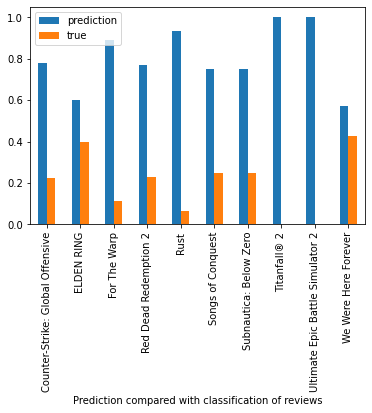

In [33]:
false_predicts = false_preds.groupby(['game_name']).mean()
false_predicts.plot(kind='bar', xlabel = 'Prediction compared with classification of reviews')

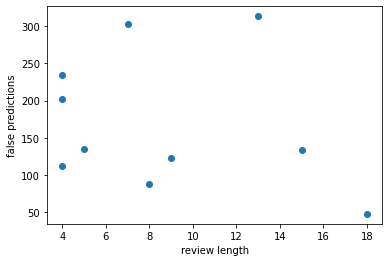

In [34]:
plt.scatter(false_preds.game_name.value_counts(), review_len)
plt.ylabel("false predictions")
plt.xlabel("review length");

<AxesSubplot:title={'center':'review_length'}, xlabel='game_name'>

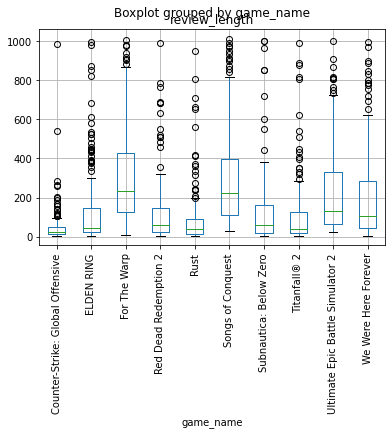

In [58]:
reviews.boxplot(column="review_length", by="game_name", rot=90)




<AxesSubplot:title={'center':'hours_played'}, xlabel='game_name'>

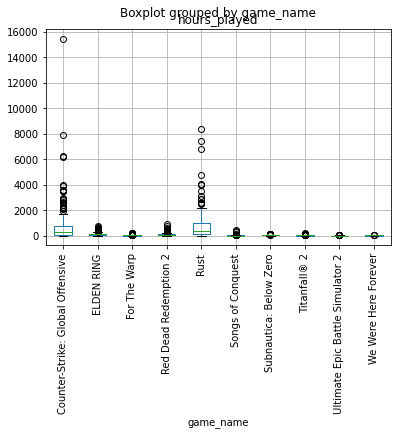

In [62]:
reviews.boxplot(column="hours_played", by="game_name", rot=90)